In [1]:
# Step 0: Install/Import
# (Run the pip line only if needed)
# !pip install scikit-learn matplotlib pandas joblib

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)


In [2]:
# Step 1: Load dataset
DATA_PATH = "bank.csv"     # change if your file is elsewhere
assert os.path.exists(DATA_PATH), f"Can't find {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Step 2: Choose your target column
POSSIBLE_TARGETS = ["y", "deposit", "subscribed", "purchased", "target", "Outcome"]

TARGET = None
for c in POSSIBLE_TARGETS:
    if c in df.columns:
        TARGET = c
        break

# Fallback: try last object/bool column with <=3 unique values
if TARGET is None:
    for c in df.columns[::-1]:
        if (df[c].dtype == "object" or str(df[c].dtype).startswith("bool")) and df[c].nunique(dropna=True) <= 3:
            TARGET = c
            break

# Last-resort: use the last column
if TARGET is None:
    TARGET = df.columns[-1]

TARGET


'deposit'

In [4]:
# Step 3: Clean and build X, y
data = df.copy()
y_raw = data[TARGET]

# Convert target to 0/1
if y_raw.dtype == "object":
    mapping = {
        "yes": 1, "no": 0, "y": 1, "n": 0,
        "true": 1, "false": 0, "success": 1, "failure": 0,
        "subscribed": 1, "not subscribed": 0
    }
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)

    # If any unmapped values remain, fallback:
    if y.isna().any():
        vals = y_raw.astype(str).str.strip()
        if vals.nunique() == 2:
            positive = vals.value_counts().index[-1]  # rarer value -> positive
            y = (vals == positive).astype(int)
        else:
            y = vals.str.lower().str.contains("yes|y|true|success|subscribed").astype(int)
else:
    y = y_raw.astype(int)

# Drop rows with missing target
mask = ~pd.isna(y)
data = data.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# Features
X = data.drop(columns=[TARGET])

# Split categorical vs numeric
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if c not in num_cols]

# Basic NA handling
for c in num_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna("Unknown")

len(num_cols), len(cat_cols), TARGET


(7, 9, 'deposit')

In [5]:
# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((8929, 16), (2233, 16))

In [7]:
# Step 5: Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# Step 6: Baseline Decision Tree (no pruning yet)
tree = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([("prep", preprocessor), ("model", tree)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]


{'accuracy': 0.7890729959695477, 'precision': 0.7846750727449079, 'recall': 0.7646502835538752, 'f1': 0.7745332695069411, 'roc_auc': np.float64(0.7878570566705545)}

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1175
           1       0.78      0.76      0.77      1058

    accuracy                           0.79      2233
   macro avg       0.79      0.79      0.79      2233
weighted avg       0.79      0.79      0.79      2233



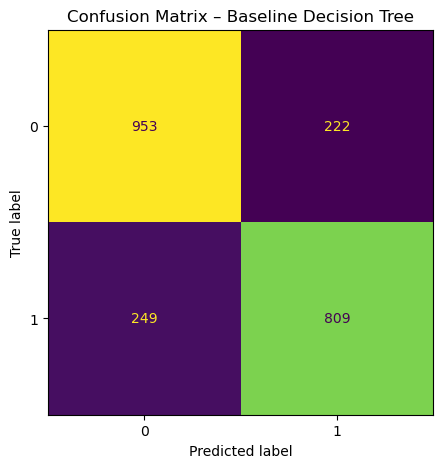

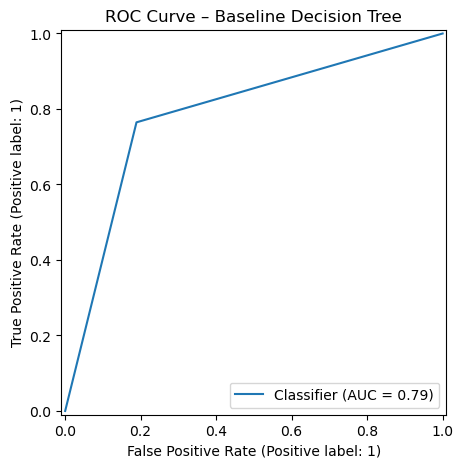

In [8]:
# Step 7: Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print({
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc
})
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix (matplotlib only, one plot)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay(cm).plot(ax=ax, colorbar=False)
plt.title("Confusion Matrix – Baseline Decision Tree")
plt.show()

# ROC curve (matplotlib only, one plot)
fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
plt.title("ROC Curve – Baseline Decision Tree")
plt.show()


In [9]:
# Step 8: Search ccp_alpha by CV
param_grid = {"model__ccp_alpha": np.linspace(0.0, 0.02, 11)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",   # you can use 'roc_auc' as well
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_pipe = grid.best_estimator_
best_alpha = grid.best_params_["model__ccp_alpha"]
best_alpha


np.float64(0.002)

In [10]:
# Step 9: Evaluate pruned model
y_pred_best = best_pipe.predict(X_test)
y_proba_best = best_pipe.predict_proba(X_test)[:, 1]

acc_b = accuracy_score(y_test, y_pred_best)
prec_b = precision_score(y_test, y_pred_best, zero_division=0)
rec_b = recall_score(y_test, y_pred_best, zero_division=0)
f1_b = f1_score(y_test, y_pred_best, zero_division=0)
roc_b = roc_auc_score(y_test, y_proba_best)

print("Best ccp_alpha:", best_alpha)
print({
    "accuracy": acc_b, "precision": prec_b, "recall": rec_b, "f1": f1_b, "roc_auc": roc_b
})


Best ccp_alpha: 0.002
{'accuracy': 0.8208687863860278, 'precision': 0.789103690685413, 'recall': 0.8487712665406427, 'f1': 0.8178506375227687, 'roc_auc': np.float64(0.8840952419257531)}


In [11]:
# Step 10: Feature importances
ohe = best_pipe.named_steps["prep"].named_transformers_["cat"]
ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
final_feature_names = ohe_names + num_cols

tree_model = best_pipe.named_steps["model"]
importances = getattr(tree_model, "feature_importances_", None)

if importances is not None and len(importances) == len(final_feature_names):
    fi = (
        pd.DataFrame({"feature": final_feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
    )
    fi.head(20)
else:
    print("Feature importances unavailable or name mismatch.")


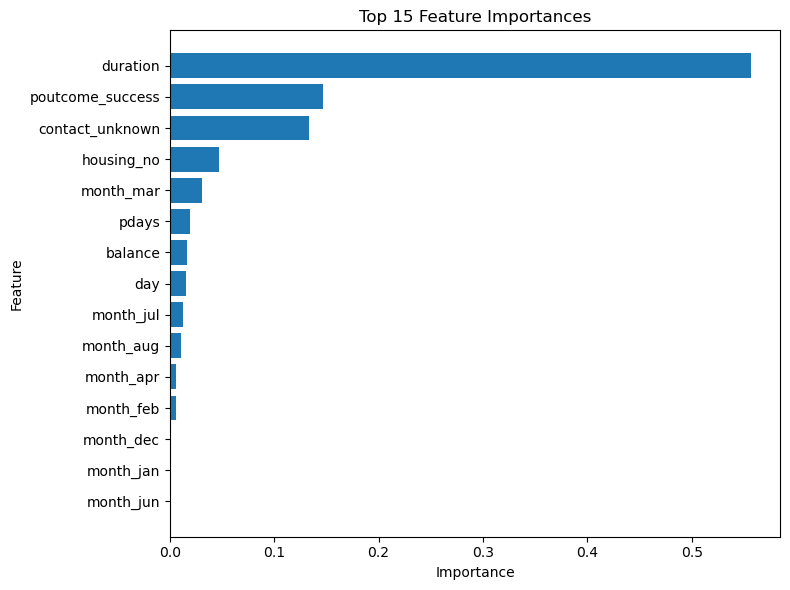

In [12]:
# Step 11: Plot top 15 feature importances
if importances is not None and len(importances) == len(final_feature_names):
    top = fi.head(15).iloc[::-1]  # reverse for horizontal bar
    plt.figure(figsize=(8,6))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Top 15 Feature Importances")
    plt.tight_layout()
    plt.show()


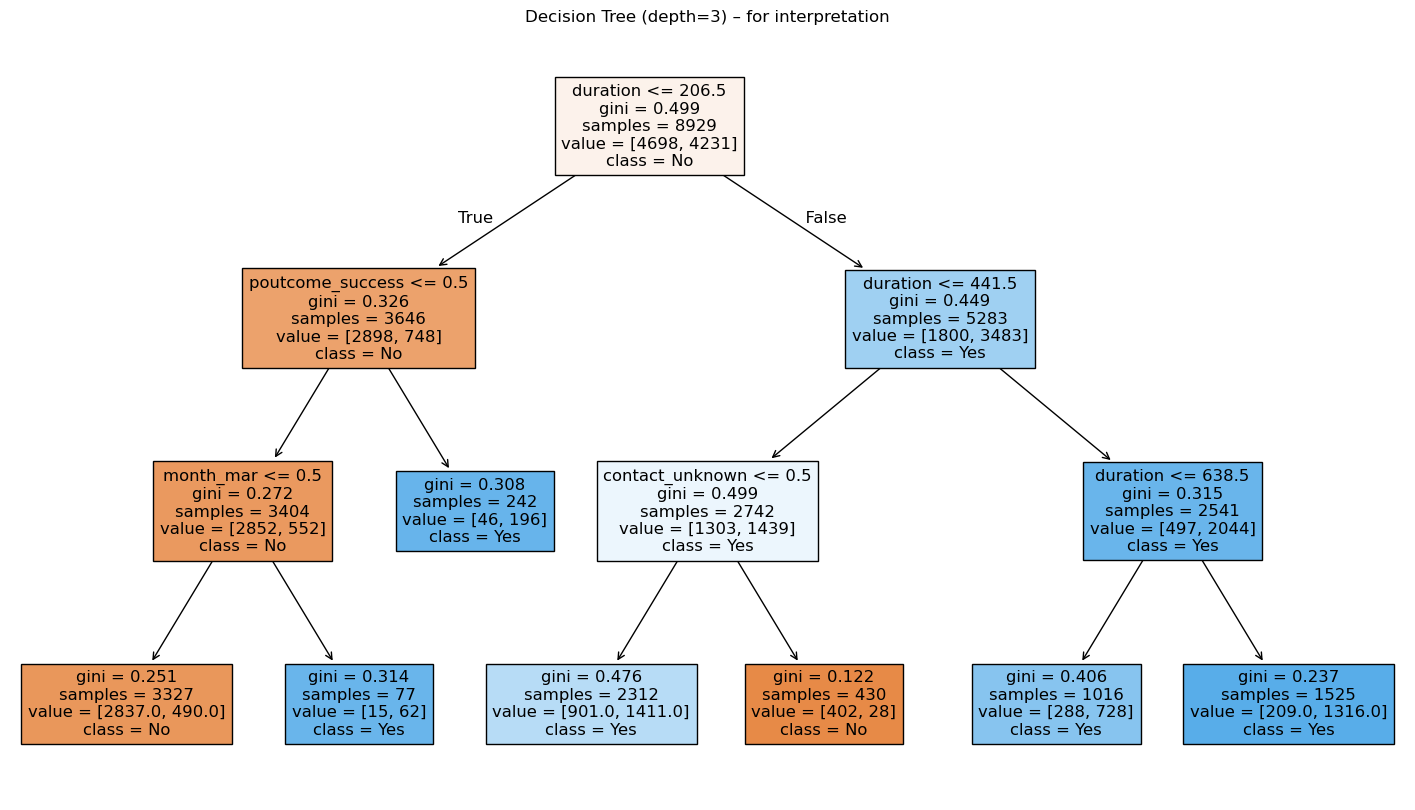

In [13]:
# Step 12: Visualize a shallow tree (depth=3)
from sklearn.base import clone

# Fit preprocessor alone to get transformed matrix & names
prep = best_pipe.named_steps["prep"]
X_train_mat = prep.fit_transform(X_train, y_train)

viz_tree = clone(tree_model).set_params(max_depth=3, random_state=42)
viz_tree.fit(X_train_mat, y_train)

plt.figure(figsize=(18,10))
plot_tree(viz_tree, filled=True, feature_names=final_feature_names, class_names=["No", "Yes"])
plt.title("Decision Tree (depth=3) – for interpretation")
plt.show()


In [14]:
# Step 13: Save model and a quick metrics report
joblib.dump(best_pipe, "decision_tree_bank_model.pkl")

report = {
    "target_column": TARGET,
    "baseline": {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "roc_auc": float(roc)},
    "best": {"ccp_alpha": float(best_alpha), "accuracy": float(acc_b), "precision": float(prec_b), "recall": float(rec_b), "f1": float(f1_b), "roc_auc": float(roc_b)},
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "num_features_numeric": len(num_cols),
    "num_features_categorical": len(cat_cols)
}
with open("report.json", "w") as f:
    json.dump(report, f, indent=2)

print("Saved: decision_tree_bank_model.pkl, report.json")


Saved: decision_tree_bank_model.pkl, report.json
